In [1]:
from __future__ import division
from collections import Counter # Counter() is a dict for counting
from collections import defaultdict
from numpy import mean
import numpy as np
import pandas as pd


In [2]:
# Sentiment values
sentiments = ["positive","neutral","negative"]
# List of positive words:
pos_words = ["love", "great", "like"]
# List of negative words:
neg_words = ["hate", "bad", "annoy"]
# List of target companies:
companies = ["@virginamerica", "@united", "@southwestair", "@jetblue", "@usairways", "@americanair"]
sentiment_words = pos_words+neg_words

def s2id(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 2
    else:
        print("ERROR: bad value!!")
        return -1
 

In [3]:
#remove any counts from dictionary if it's below min_threshold or above max_treshold
#max_threshold is ignored if unset
def filter_occ_counts(counts, min_threshold, max_threshold=0):
    if (max_threshold > 0):
        return Counter({w : counts[w] for w in counts.keys() if counts[w] > min_threshold and counts[w] < max_threshold})
    else:
        return Counter({w : counts[w] for w in counts.keys() if counts[w] > min_threshold})

#remove any co-occurence counts if below threshold 
def filter_cooc_counts(co_counts, min_threshold):
     return {w: filter_occ_counts(co_counts[w], min_threshold) for w in co_counts.keys()}


In [4]:
def PMI(c_xy, c_x, c_y, N):
    # Computes PMI(x, y) where
    # c_xy is the number of times x co-occurs with y
    # c_x is the number of times x occurs.
    # c_y is the number of times y occurs.
    # N is the number of observations.
    p_xy = c_xy/N 
    p_x = c_x/N 
    p_y = c_y/N 
    pmi = np.log2( p_xy / (p_x*p_y) )
    
    return pmi;

#Do a simple error check using value computed by hand
if(PMI(2,4,3,12) != 1): # these numbers are from our y,z example
    print("Warning: PMI is incorrectly defined")
else:
    print("PMI check passed")


PMI check passed


In [5]:
# Define the data structures used to store the counts:
occ_counts = Counter(); # Occurrence counts
cooc_counts = defaultdict(Counter); # Co-occurrence counts:

#This will be indexed by target words. cooc_counts[companies] will contain
#a dictionary of co-occurrence counts of companies with each sentiment word.
df = pd.read_csv("Tweets_short.csv", index_col=0)
df['text'] = df['text'].str.lower()
N = len(df)
print("Total number of tweets: {}".format(len(df)))
#df['airline_sentiment']
#for tweet in df['text']:
for sentiment, tweet in df.itertuples(index=False):
    #print("{} {}".format(sentiment,tweet))
    words = set(tweet.strip().split()) #remove duplicate words
    #print(words)
    for word in words:
        occ_counts[word] += 1 # Store occurence counts for all words
        # but only get co-occurrence counts for companies/sentiment word pairs
        if word in companies:
            for word2 in words:
                if word2 in sentiment_words:
                    cooc_counts[word][word2] += 1 # Store co-occurence counts




Total number of tweets: 14640


In [6]:
#For a Counter c, c.most_common(n) returns a sorted list of the n most common 
#items in c. If no n is given, it returns all items, sorted by decreasing frequency
print("Counts of positive words:")
print(Counter({w : occ_counts[w] for w in pos_words}).most_common())
print("Counts of negative words:")
print(Counter({w : occ_counts[w] for w in neg_words}).most_common())
print("Counts of target words:")
print(Counter({w : occ_counts[w] for w in companies}).most_common())
print()
for company in companies:
    print("{} cooc counts: {}".format(company, cooc_counts[company].most_common()))


#Do some simple error checks using value computed beforehand
print()
if occ_counts['like'] != 411:
    print("Warning: counting is incorrectly defined")
elif occ_counts['hate'] != 37:
    print("Warning: counting is incorrectly defined")
elif cooc_counts['@jetblue']['love'] != 50:
    print("Warning: counting is incorrectly defined")
elif cooc_counts['@usairways']['bad'] != 34:
    print("Warning: counting is incorrectly defined")
else:
    print("Counting check passed")
    

Counts of positive words:
[('like', 411), ('great', 252), ('love', 213)]
Counts of negative words:
[('bad', 148), ('hate', 37), ('annoy', 0)]
Counts of target words:
[('@united', 3738), ('@usairways', 2923), ('@americanair', 2876), ('@southwestair', 2384), ('@jetblue', 2009), ('@virginamerica', 493)]

@virginamerica cooc counts: [('love', 22), ('great', 14), ('like', 13), ('bad', 4)]
@united cooc counts: [('like', 111), ('great', 48), ('bad', 34), ('love', 26), ('hate', 13)]
@southwestair cooc counts: [('love', 68), ('like', 67), ('great', 52), ('bad', 22), ('hate', 4)]
@jetblue cooc counts: [('like', 55), ('great', 53), ('love', 50), ('bad', 14), ('hate', 4)]
@usairways cooc counts: [('like', 70), ('great', 46), ('bad', 34), ('love', 18), ('hate', 11)]
@americanair cooc counts: [('like', 87), ('bad', 40), ('great', 34), ('love', 29), ('hate', 3)]

Counting check passed


In [7]:
#filter out co-occurrences with too few counts if you want
#cooc_counts = filter_cooc_counts(cooc_counts, 2)

for company in companies:
    company_count = occ_counts[company]
    posPMIs = []
    negPMIs = []
    # compute PMI between target and each positive word, and
    # add it to the list of positive sentiment PMI values
    for pos in pos_words:
        if(pos in cooc_counts[company]): # Check if the words actually co-occur
            # If so, compute PMI and append to the list
            posPMIs.append(PMI(cooc_counts[company][pos],company_count,occ_counts[pos],N)); 
    # same for negative sentiment words
    for neg in neg_words:
        if(neg in cooc_counts[company]): 
            negPMIs.append(PMI(cooc_counts[company][neg],company_count,occ_counts[neg],N));
    #uncomment the following line when posPMIs and negPMIs are no longer empty.
    print("{:14s}: {:5.2f} (pos), {:5.2f} (neg)".format((company).ljust(12), mean(posPMIs), mean(negPMIs)))


@virginamerica:  0.75 (pos), -0.32 (neg)
@united       : -0.47 (pos),  0.15 (neg)
@southwestair :  0.44 (pos), -0.36 (neg)
@jetblue      :  0.45 (pos), -0.44 (neg)
@usairways    : -0.53 (pos),  0.39 (neg)
@americanair  : -0.32 (pos), -0.41 (neg)


# Gradable method

In [8]:
valence = pd.read_csv("valence_lexicon_small.tsv", sep='\t', index_col=0)['Valence'].to_dict()

negation_words = []
with open("negation_words.txt", 'rt') as fd:
    negation_words = [line.rstrip() for line in fd]
#print(negation_words)

#See https://en.wiktionary.org/wiki/Category:English_degree_adverbs
strengthen_words = pd.read_csv("strengthen_words.tsv", sep='\t', index_col=0)['score'].to_dict()
#print(strengthen_words)

weaken_words = pd.read_csv("weaken_words.tsv", sep='\t', index_col=0)['score'].to_dict()
#print(weaken_words)

exclamation_words = {'!':0.1, "!!":0.2, "!!!":0.3}


In [9]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum()

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

######### TH = 0.05
[[1807.  382.  174.]
 [1218. 1437.  444.]
 [3290. 2069. 3819.]]
0.4824453551912568


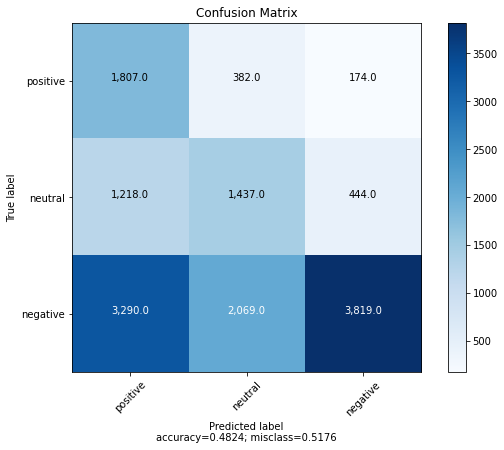

In [10]:
# Gradable method

# This threshold is used to distinguish between negative / neutral / positive tweets
# negative < -threshold <= neutral <= +threshold < positive
threshold = 0.05
cm = np.zeros((3,3))

sentiment_predictions = []

for sentiment, tweet in df.itertuples(index=False):
    tweet_valence = 0
    words = tweet.strip().split()
    for w in words:
        if w in valence:
            tweet_valence += valence[w]
        if w in negation_words:
            tweet_valence *= -0.8
        if w in exclamation_words:
            tweet_valence += exclamation_words[w]
        if w in strengthen_words:
            tweet_valence += strengthen_words[w]
        if w in weaken_words:
            tweet_valence += weaken_words[w]
    
    if tweet_valence > threshold:
        sentiment_pred = 'positive'
        sentiment_predictions.append('positive')
    elif tweet_valence < -threshold:
        sentiment_pred = 'negative'
        sentiment_predictions.append('negative')
    else: # tweet_valence == 0:
        sentiment_pred = 'neutral'
        sentiment_predictions.append('neutral')        
        
    cm[s2id(sentiment)][s2id(sentiment_pred)] += 1

    
print("######### TH = {}".format(threshold))
print(cm)
precision = np.trace(cm) / np.sum(cm)
print(precision)

plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = sentiments,
                      title        = "Confusion Matrix")

